# Accident Severity Classification

## Outline 

1. Introduction 
2. Data preparation 
      * 2.1 Load data
      * 2.2 Sample the data
      * 2.3 Check for missing values (NaN)
      * 2.4 Exploratory Visualization
      * 2.5 Create a new dataframe
      * 2.6 Split features and targets from the data
3. Training/Predicting Pipeline 
4. Prediction and submission 
      * 4.1 Logistic Regression
      * 4.2 Random Forest Classifier
      * 4.3 Using the Full Estimator

## 1. Introduction

The UK government collects and publishes (usually on an annual basis) detailed information about traffic accidents across the country. This information includes, but is not limited to, geographical locations, weather conditions, type of vehicles, number of casualties and vehicle manoeuvres, making this a very interesting and comprehensive dataset for analysis and research. 

The data come from the Open Data website of the UK government, where they have been published by the Department of Transport. 

The dataset comprises of two csv files: 

* Accident_Information.csv: every line in the file represents a unique traffic accident (identified by the Accident_Index column), featuring various properties related to the accident as columns. Date range: 2005-2017 
* Vehicle_Information.csv: every line in the file represents the involvement of a unique vehicle in a unique traffic accident, featuring various vehicle and passenger properties as columns. Date range: 2004-2016 

Our target is to predict the accident severity. The severity is devided to two catagories; severe and slight. 

We had more than 2 million observations and close to 60 features. So, we sampled the data into about 600K observations and 23 features. 

Two models were selected - Logistic Regression and the Random Forest Classifier. 

In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime as dt
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
#from pandas.tools.plotting import scatter_matrix
import warnings
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, OneHotEncoder, KBinsDiscretizer, MaxAbsScaler
from sklearn.feature_selection import VarianceThreshold

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import seaborn as sns
sns.set()
import math

warnings.filterwarnings('ignore')
%matplotlib inline

import os
print(os.listdir(r"C:\Users\157088\Desktop\Coding and projects\Coursera\Coursera_Capstone\Data"))

['Accident_Information.csv', 'Vehicle_Information.csv']


## 2. Data Preparation

### 2.1 Load Data

In [20]:
#Load Data and encode to latin
acc = pd.read_csv(r'C:\Users\157088\Desktop\Coding and projects\Coursera\Coursera_Capstone\Data\Accident_Information.csv', encoding = 'latin')
veh = pd.read_csv(r'C:\Users\157088\Desktop\Coding and projects\Coursera\Coursera_Capstone\Data\Vehicle_Information.csv', encoding = 'latin')

# Merging two data sets into one with inner join by index
df = pd.merge(veh, acc, how = 'inner', on = 'Accident_Index')

#Check data sample
print(df.shape)
df.head()

(2058408, 57)


,Accident_Index,Age_Band_of_Driver,Age_of_Vehicle,Driver_Home_Area_Type,Driver_IMD_Decile,Engine_Capacity_.CC.,Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,Journey_Purpose_of_Driver,Junction_Location,...,Police_Force,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Year_y,InScotland
0,200501BS00002,36 - 45,3.0,Data missing or out of range,NaN,8268.0,None,None,Journey as part of work,Leaving roundabout,...,Metropolitan Police,Dry,Dual carriageway,None,30.0,17:36,Urban,Fine no high winds,2005,No
1,200501BS00003,26 - 35,5.0,Urban area,3.0,8300.0,Parked vehicle,None,Journey as part of work,Not at or within 20 metres of junction,...,Metropolitan Police,Dry,Single carriageway,None,30.0,00:15,Urban,Fine no high winds,2005,No
2,200501BS00004,46 - 55,4.0,Urban area,1.0,1769.0,None,None,Other/Not known (2005-10),Not at or within 20 metres of junction,...,Metropolitan Police,Dry,Single carriageway,None,30.0,10:35,Urban,Fine no high winds,2005,No
3,200501BS00005,46 - 55,10.0,Data missing or out of range,NaN,85.0,Kerb,None,Other/Not known (2005-10),Not at or within 20 metres of junction,...,Metropolitan Police,Wet or damp,Single carriageway,None,30.0,21:13,Urban,Fine no high winds,2005,No
4,200501BS00006,46 - 55,1.0,Urban area,4.0,2976.0,None,None,Other/Not known (2005-10),Not at or within 20 metres of junction,...,Metropolitan Police,Wet or damp,Single carriageway,Oil or diesel,30.0,12:40,Urban,Raining no high winds,2005,No




### 2.2 Sample the data

by reducing rows with Slight Accident Severity

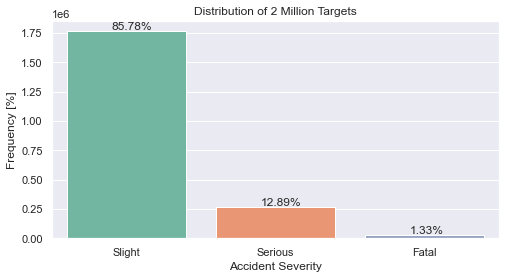

In [21]:
#Distribution of original data by targets

ax = sns.countplot(x = df.Accident_Severity ,palette="Set2")
sns.set(font_scale=1)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(8,4)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(df.Accident_Severity)), (p.get_x()+ 0.3, p.get_height()+10000))

plt.title('Distribution of 2 Million Targets',)
plt.xlabel('Accident Severity')
plt.ylabel('Frequency [%]')
plt.show()

In [22]:
# Creating weights that are opposite to the weights of target
weights = np.where(df['Accident_Severity'] == 'Slight', .2, .8)

#Sampling only 30% of the data with new weights  
df = df.sample(frac=0.3, replace=True, weights=weights)
print(df.shape)
#df.Accident_Severity.value_counts(normalize=True)

(617522, 57)


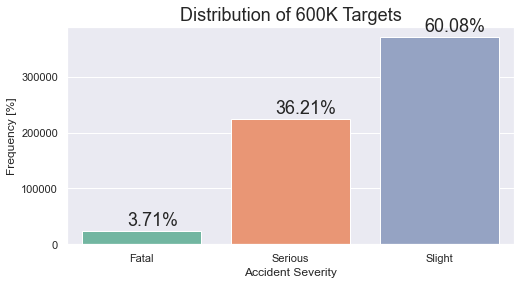

In [23]:
#Distribution of sample data by targets

ax = sns.countplot(x = df.Accident_Severity ,palette="Set2")
sns.set(font_scale=1.5)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(8,4)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(df.Accident_Severity)), (p.get_x()+ 0.3, p.get_height()+10000))

plt.title('Distribution of 600K Targets',)
plt.xlabel('Accident Severity')
plt.ylabel('Frequency [%]')
plt.show()

### 2.3 Checking for missing values

some will be filled, some will get omitted

In [24]:
#Missing values for each column
null_count = df.isnull().sum()
null_count[null_count>0]#.plot('bar', figsize=(30,10))

Age_of_Vehicle                                 103103
Driver_IMD_Decile                              207480
Engine_Capacity_.CC.                            76297
make                                            34587
model                                           97208
Propulsion_Code                                 71037
Vehicle_Location.Restricted_Lane                  284
2nd_Road_Class                                 263522
2nd_Road_Number                                  5673
Did_Police_Officer_Attend_Scene_of_Accident        40
Latitude                                           40
Location_Easting_OSGR                              40
Location_Northing_OSGR                             40
Longitude                                          40
LSOA_of_Accident_Location                       44972
Pedestrian_Crossing-Human_Control                 197
Pedestrian_Crossing-Physical_Facilities           369
Speed_limit                                        12
Time                        

### 2.4 Exploratory Visualization

#### Age of Vehicle

Min: 1.0 
Max: 111.0 
Median: 7.0


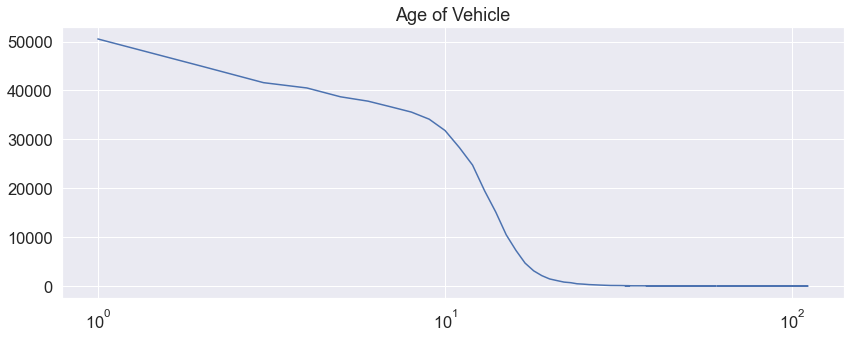

In [25]:
(df.Age_of_Vehicle
 .value_counts()
 .plot(title = "Age of Vehicle", 
       logx = True, 
       figsize=(14,5)))

print('Min:',    df.Age_of_Vehicle.min(), '\n'
      'Max:',    df.Age_of_Vehicle.max(), '\n'
      'Median:', df.Age_of_Vehicle.median())

In [40]:
df.head()

,Accident_Index,Age_Band_of_Driver,Age_of_Vehicle,Driver_Home_Area_Type,Driver_IMD_Decile,Engine_Capacity_.CC.,Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,Journey_Purpose_of_Driver,Junction_Location,...,Police_Force,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Year_y,InScotland
204626,200650A31I084,26 - 35,8.0,Urban area,2.0,3301.0,None,None,Data missing or out of range,Approaching junction or waiting/parked at junc...,...,Devon and Cornwall,Dry,One way street,None,60.0,16:00,Urban,Fine no high winds,2006,No
1684606,2015320043187,56 - 65,4.0,Urban area,NaN,12900.0,None,None,Journey as part of work,Not at or within 20 metres of junction,...,Lincolnshire,Dry,Single carriageway,None,60.0,07:10,Rural,Fine no high winds,2015,No
42777,2005160D06700,26 - 35,7.0,Urban area,1.0,1299.0,None,None,Other/Not known (2005-10),Mid Junction - on roundabout or on main road,...,Humberside,Dry,Dual carriageway,None,30.0,15:15,Urban,Fine no high winds,2005,No
719320,2010550C37115,26 - 35,5.0,Urban area,5.0,2953.0,None,None,Other/Not known (2005-10),Mid Junction - on roundabout or on main road,...,Dorset,Wet or damp,Single carriageway,None,30.0,13:29,Urban,Raining no high winds,2010,No
1682711,201531D226715,36 - 45,16.0,Urban area,NaN,1780.0,None,None,Not known,Mid Junction - on roundabout or on main road,...,Nottinghamshire,Wet or damp,Single carriageway,None,30.0,20:55,Urban,Fine no high winds,2015,No


### 2.5 Create a new dataframe

with only the features we need and want, 25 features overall

In [41]:
df2 = df[['Accident_Index', '1st_Road_Class','Day_of_Week', 'Junction_Detail','Light_Conditions', 'Number_of_Casualties',
          'Number_of_Vehicles', 'Road_Surface_Conditions', 'Road_Type', 'Special_Conditions_at_Site', 'Speed_limit',
          'Time', 'Urban_or_Rural_Area', 'Weather_Conditions', 'Age_Band_of_Driver', 'Age_of_Vehicle',
          'Hit_Object_in_Carriageway', 'Hit_Object_off_Carriageway', 'make', 'Engine_Capacity_.CC.', 'Sex_of_Driver',
          'Skidding_and_Overturning', 'Vehicle_Manoeuvre', 'Vehicle_Type', 'Accident_Severity'
         ]]

In [42]:
df2.head()

,Accident_Index,1st_Road_Class,Day_of_Week,Junction_Detail,Light_Conditions,Number_of_Casualties,Number_of_Vehicles,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,...,Age_of_Vehicle,Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,make,Engine_Capacity_.CC.,Sex_of_Driver,Skidding_and_Overturning,Vehicle_Manoeuvre,Vehicle_Type,Accident_Severity
204626,200650A31I084,Unclassified,Saturday,T or staggered junction,Daylight,1,1,Dry,One way street,None,...,8.0,None,None,CHRYSLER,3301.0,Male,None,Going ahead other,Car,Fatal
1684606,2015320043187,A,Friday,Not at junction or within 20 metres,Daylight,1,2,Dry,Single carriageway,None,...,4.0,None,None,DAF TRUCKS,12900.0,Male,None,Going ahead right-hand bend,Goods 7.5 tonnes mgw and over,Serious
42777,2005160D06700,A,Friday,T or staggered junction,Daylight,1,1,Dry,Dual carriageway,None,...,7.0,None,None,PROTON,1299.0,Female,None,Reversing,Car,Slight
719320,2010550C37115,B,Wednesday,T or staggered junction,Daylight,3,2,Wet or damp,Single carriageway,None,...,5.0,None,None,NISSAN,2953.0,Male,None,Going ahead other,Van / Goods 3.5 tonnes mgw or under,Slight
1682711,201531D226715,A,Friday,T or staggered junction,Darkness - lights lit,1,2,Wet or damp,Single carriageway,None,...,16.0,None,None,AUDI,1780.0,Male,None,Going ahead other,Car,Slight


#### Correlation matrix

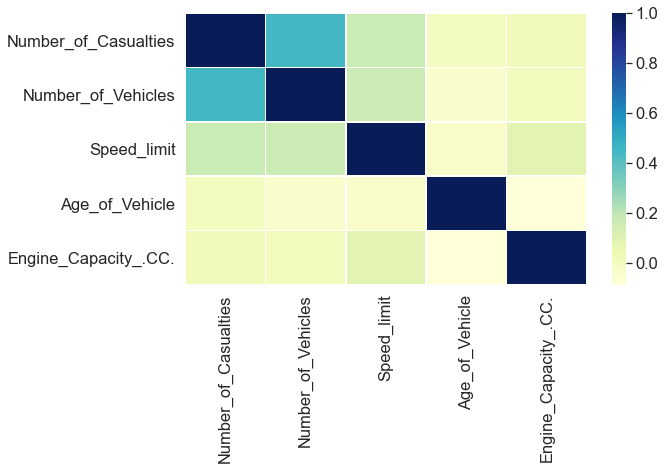

In [43]:
plt.figure(figsize=(9,5))
sns.heatmap(df2.corr(),linewidths=.5,cmap="YlGnBu")
plt.show()

#### Number of Vehicles Distribution

Min: 1 
Max: 67 
Median: 2.0


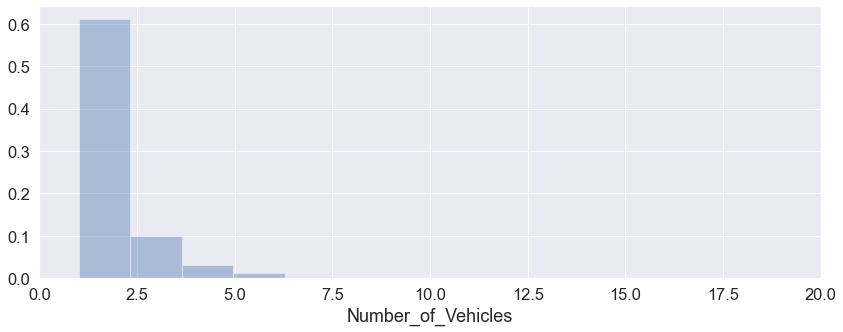

In [46]:
plt.figure(figsize=(14,5))
sns.distplot(df2.Number_of_Vehicles).set_xlim(0,20)
print('Min:',    df2.Number_of_Vehicles.min(), '\n'
      'Max:',    df2.Number_of_Vehicles.max(), '\n'
      'Median:', df2.Number_of_Vehicles.median())

#### Number of casualties distribution

Min: 1 
Max: 93 
Median: 1.0


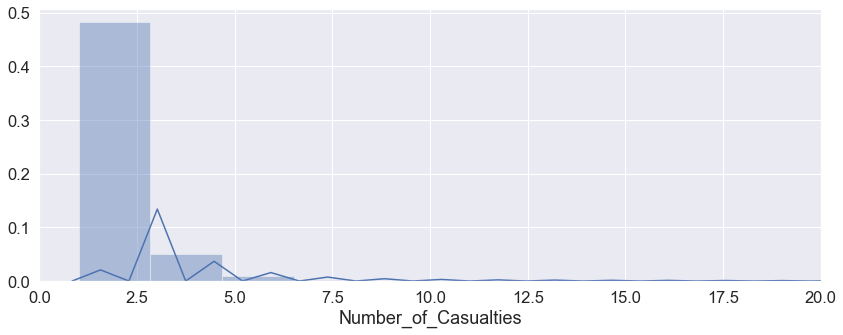

In [45]:
plt.figure(figsize=(14,5))
sns.distplot(df2.Number_of_Casualties).set_xlim(0,20)
print('Min:',    df2.Number_of_Casualties.min(), '\n'
      'Max:',    df2.Number_of_Casualties.max(), '\n'
      'Median:', df2.Number_of_Casualties.median())

#### From multiclass to two-classes

In [48]:
df2['Accident_Severity'] = df2['Accident_Severity'].replace(['Serious', 'Fatal'], 'Serious or Fatal')
df2 = pd.get_dummies(df2, columns=['Accident_Severity'])
df2 = df2.drop('Accident_Severity_Serious or Fatal', axis=1)
df2.Accident_Severity_Slight.value_counts(normalize=True)

1    0.600809
0    0.399191
Name: Accident_Severity_Slight, dtype: float64

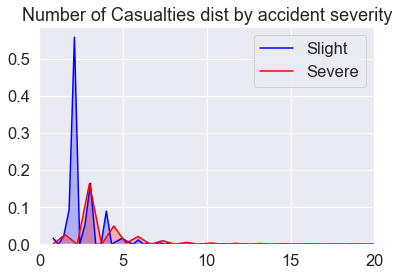

In [49]:
acc_slight = df2.Accident_Severity_Slight == 1
acc_severe = df2.Accident_Severity_Slight == 0

sns.kdeplot(df2.Number_of_Casualties[acc_slight],shade=True,color='Blue', label='Slight').set_xlim(0,20)
sns.kdeplot(df2.Number_of_Casualties[acc_severe],shade=True,color='Red', label='Severe').set_xlim(0,20)

plt.title('Number of Casualties dist by accident severity')
plt.show()

#print("we can see distribution between failed (under 2000), and successful (bigger the 2000)")

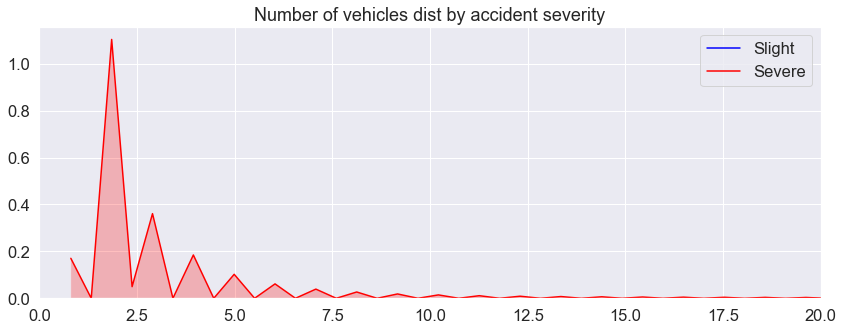

In [50]:
plt.figure(figsize=(14,5))

sns.kdeplot(df2.Number_of_Vehicles[acc_slight],shade=True,color='Blue', label='Slight').set_xlim(0,20)
sns.kdeplot(df2.Number_of_Vehicles[acc_severe],shade=True,color='Red', label='Severe').set_xlim(0,20)

plt.title('Number of vehicles dist by accident severity')
plt.show()

#print("we can see distribution between failed (under 2000), and successful (bigger the 2000)")

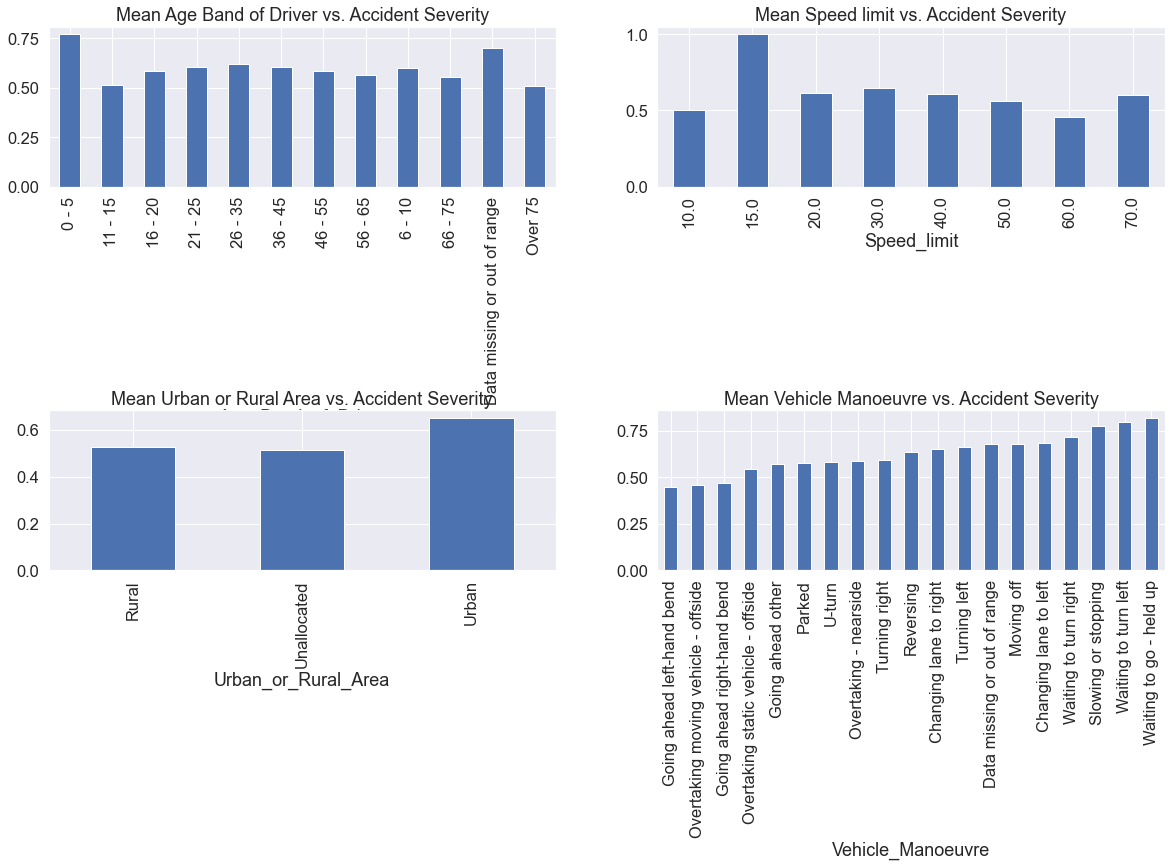

In [51]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
plt.subplots_adjust(hspace=1.4)

(df2.groupby(['Age_Band_of_Driver'])
 .mean()
 ['Accident_Severity_Slight']
 .sort_index()
 .plot
 .bar(title = "Mean Age Band of Driver vs. Accident Severity",
      ax = axes[0,0]))

(df2.groupby(['Speed_limit'])
 .mean()
 ['Accident_Severity_Slight']
 .sort_index()
 .plot
 .bar(title = "Mean Speed limit vs. Accident Severity",
      ax = axes[0,1]))

(df2.groupby(['Urban_or_Rural_Area'])
 .mean()
 ['Accident_Severity_Slight']
 .sort_index()
 .plot
 .bar(title = "Mean Urban or Rural Area vs. Accident Severity",
      ax = axes[1,0]))

(df2.groupby(['Vehicle_Manoeuvre'])
 .mean()
 ['Accident_Severity_Slight']
 .sort_values()
 .plot
 .bar(title = "Mean Vehicle Manoeuvre vs. Accident Severity",
      ax = axes[1,1]))

plt.show()

#### 2.6 Split features and targets from the data

In [52]:
X = df2.drop(['Accident_Index','Accident_Severity_Slight'], axis=1)
y = df2.Accident_Severity_Slight
print(X.shape,
      y.shape)

(617522, 23) (617522,)
